In [1]:
!pip install geopandas
!pip install cdflib


# <div align="center">TP n° 2: Building a geomagnetic field model</div>


## 1 Introduction

The Earth's magnetic field, also known as the geomagnetic field, expands from Earth's interior out into space. 
It results from differents sources. The main one is called the geodynamo: motions of (electrically conducting) molten iron alloy in the Earth's core (of radius 3485 km, $\approx 3000$ km below our feets) induce a magnetic field (by a combination of Maxwells laws, and the conservation of heat and momentum). 
These convection currents are caused by heat being extracted from the core.
At the Earth's surface, the dynamo field intensity vary between 30 000 and 60 000 nT.

![coupe_nath_small.jpg](./figs/coupe_nath_small.jpg)


*Figure: Sketck of the geomagnetic field from a dynamical simulation of the geodynamo (source: N. Schaeffer/CNRS)*

There are alternative magnetic sources. They can be divided in two categories : internal and external sources. 
On top of the dynamo field, interior sources are associated with the induced currents passing through the mantle, the remanent and induced magnetization in the crust, the charged particules motions in the oceans etc... 
The external sources are all the sources generated above the magnetometers, associated with motions of charged particles in the ionosphere and in the magnetosphere.

Swarm is European Spatial Agency's first constellation mission for Earth's observation. 
It consists of three similar satellites called Alpha, Bravo and Charlie that orbits in low altitude (approximately 500 km) and deliver a detailed survey on the geomagnetic field. 
Its function is to provide data on the temporal evolution of the field and the electrical current in the atmosphere with magnetometers and other devices. Its objective is to study the core dynamic, mapping the litosphere's magnetisation, mapping in 3D the eletrical condictivity in the mantle, study the core-mantle interactions and so one. 

From Swarm can be construcetd virtual observatory (VO) series. 
Virtual observatory data are generated by performing a regression of many data collected in a cylinder around a fix point in space (Hammer et al, 2021). 
In order not to be overloaded by to many observations, these will be the data considered here.   
The geomagnetical virtual observatory records consist of two kinds of data: the "Observed Field" that estimate the magnetic field with all of its sources and the "Core Field", that removes several contributions so as to best isolate the core contribution.

The goal: to build a model of the magnetic field from VO data. From this model, we will conduct several analyses on the time changes of the field, or illustrating some limits of the modelization depending on the data distribution or quality.

## 2 Opening the magnetic data 

The data we will use come from Swarm virtual observatory and ground observatories, these data are stored in *Computable Document Format* this format need to be openned with a python module called **cdflib**. We will use some of the function of this module to open the data file and create a dictionnary to find the data easily. The function we will use are : 
- **cdflib.CDF(path)** with which you can create a CDF class and that takes in argument the path of datas in your computer. 
- **cdf_file.cdf_info(name)** with which you get all the information from the CDF file.
- To create the dictionnary, you need to get the keys from the file with the function **info['zVariables']**. 
Finally, you can create the dictionnary : 

In [2]:
import cdflib 
import os
import numpy as np 
import geopandas as gpd
import matplotlib.pyplot as plt
from functools import lru_cache
from scipy.special import lpmv
import math
import h5py
import matplotlib

%run functions.py

cdf_dir = 'donnees/cdf_files_basic_sync_functions_201'
swarm_file = os.path.join(cdf_dir, 'SW_OPER_VOBS_4M_2__20140301T000000_20210701T000000_0201_basic_sync_functions.cdf')
cdf_read = cdflib.CDF(swarm_file)
info = cdf_read.cdf_info()
zvars = info.zVariables
alldata = {name: cdf_read.varget(name) for name in zvars}
print('>' ,alldata.keys()) # These are the keys to use to extract all the different data from our files.

> dict_keys(['Timestamp', 'Latitude', 'Longitude', 'Radius', 'B_OB', 'sigma_OB', 'B_CF', 'sigma_CF', 'Timestamp_SV', 'B_SV', 'sigma_SV'])


Now we can observe all the different keys of the dictonnary we used to store the data :
- **'Timestamp'** refers to the time data.
- (**'Radius', 'Latitude', 'Longitudes**) refers to the localisation of our observatories.
- **'B_OB'** and **'sigma_OB'** refers to the raw observations and incertitudes. 
- **'B_CF'** and **'sigma_CF'** refers to the observations cleaned from the anomalies detected in the raw observations.
- the term **'SV'** refers to the secular variations.

The next step is to plot these observations, we will use the module **matplotlib.pyplot** and a module called **cartopy** that can plot an Earth's map. 

In [3]:
# import functions and list dates... 

from functions import cdf_times_to_np_date, extract_MF_list, compute_unique_times_list

## Choice of the date and component
unique_times_list = cdf_times_to_np_date(compute_unique_times_list(alldata['Timestamp']))
print('unique times list >', unique_times_list)

unique times list > [numpy.datetime64('2014-05'), numpy.datetime64('2014-09'), numpy.datetime64('2015-01'), numpy.datetime64('2015-05'), numpy.datetime64('2015-09'), numpy.datetime64('2016-01'), numpy.datetime64('2016-05'), numpy.datetime64('2016-09'), numpy.datetime64('2017-01'), numpy.datetime64('2017-05'), numpy.datetime64('2017-09'), numpy.datetime64('2018-01'), numpy.datetime64('2018-05'), numpy.datetime64('2018-09'), numpy.datetime64('2019-01'), numpy.datetime64('2019-05'), numpy.datetime64('2019-09'), numpy.datetime64('2020-01'), numpy.datetime64('2020-05'), numpy.datetime64('2020-09'), numpy.datetime64('2021-01'), numpy.datetime64('2021-05')]


/tmp/ipykernel_617/2239620794.py:18: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))


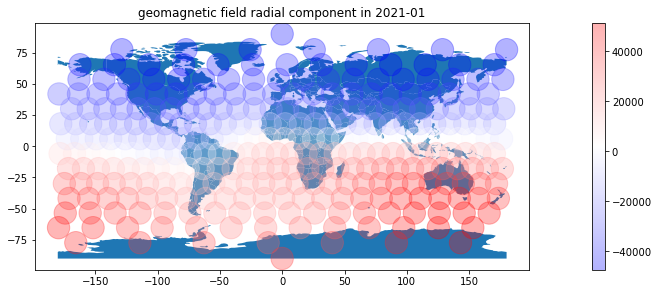

In [4]:
# choose date for plotting (among above dates): 
date = '2021-01'
index_temps = np.argwhere((cdf_times_to_np_date(alldata['Timestamp'])) == np.datetime64(date))[0][0]

# choose component for plotting: 
# [0, 1, 2] = [r, theta, phi]
choice = 0 

## Creation of the different lists
N_VO = 300
latitudes = alldata['Latitude'][index_temps:index_temps+N_VO]
longitudes = alldata['Longitude'][index_temps:index_temps+N_VO]
#print(longitudes.shape)
MF = extract_MF_list(alldata['B_CF'][index_temps:index_temps+N_VO], choice)

## plotting the geomagnetic field 
fig = plt.figure(figsize=(50,10))
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
ax1=fig.add_subplot(221)
world.plot(ax=ax1)
map_cf = ax1.scatter(longitudes, latitudes, c=MF, s=500, alpha=0.3,cmap='bwr')
if (choice==0):
    ax1.set_title("geomagnetic field radial component in "+date)
if (choice==1):
    ax1.set_title("geomagnetic field orthoradial component in "+date)
if (choice==2):
    ax1.set_title("geomagnetic field azimuthal component in "+date)
#ax1.set_title("chosen geomagnetic field component")
plt.colorbar(map_cf, ax=ax1)
plt.show()

(300,)
(258,)
[ 53.524    53.524    53.524    53.524    53.524    53.524    53.524
  53.524    53.524    53.524    53.524    53.524    53.524    53.524
  53.524    53.524    53.524    53.524    41.82612  41.82612  41.82612
  41.82612  41.82612  41.82612  41.82612  41.82612  41.82612  41.82612
  41.82612  41.82612  41.82612  41.82612  41.82612  41.82612  41.82612
  41.82612  41.82612  41.82612  41.82612  41.82612  41.82612  29.95822
  29.95822  29.95822  29.95822  29.95822  29.95822  29.95822  29.95822
  29.95822  29.95822  29.95822  29.95822  29.95822  29.95822  29.95822
  29.95822  29.95822  29.95822  29.95822  29.95822  29.95822  29.95822
  29.95822  29.95822  29.95822  29.95822  29.95822  17.96135  17.96135
  17.96135  17.96135  17.96135  17.96135  17.96135  17.96135  17.96135
  17.96135  17.96135  17.96135  17.96135  17.96135  17.96135  17.96135
  17.96135  17.96135  17.96135  17.96135  17.96135  17.96135  17.96135
  17.96135  17.96135  17.96135  17.96135  17.96135  17.96135  17.96

/tmp/ipykernel_617/177220935.py:15: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))


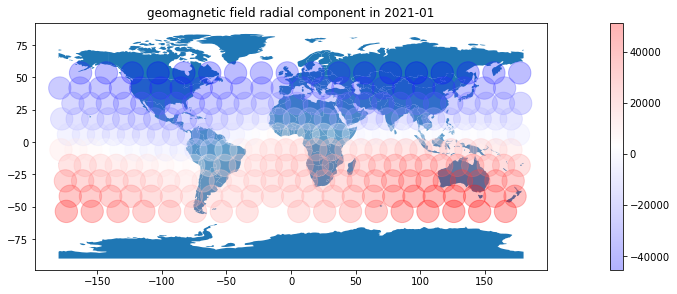

In [5]:
# example for plotting only the field at latitudes less than 60 degrees... 

print(latitudes.shape)
#print(longitudes.shape)
II = np.where(np.abs(latitudes)<60)
II = np.asarray(II)[0,:]
print(II.shape)
I1 = np.min(II)
I2 = np.max(II)
print(latitudes[I1:I2])
#print(MF[I1:I2])

## Lines plotting the geomagnetic field 
fig = plt.figure(figsize=(50,10))
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
ax1=fig.add_subplot(221)
world.plot(ax=ax1)
map_cf = ax1.scatter(longitudes[I1:I2], latitudes[I1:I2], c=MF[I1:I2], s=500, alpha=0.3,cmap='bwr')
if (choice==0):
    ax1.set_title("geomagnetic field radial component in "+date)
if (choice==1):
    ax1.set_title("geomagnetic field orthoradial component in "+date)
if (choice==2):
    ax1.set_title("geomagnetic field azimuthal component in "+date)
plt.colorbar(map_cf, ax=ax1)
plt.show()


Note : For now, we did only use the core field data that are cleaned from the external sources. But you can change the key of the computed MF to 'B_OB' to see the non-cleared data from the external sources. 

## 3 the magnetic field, a potential field

### 3.1 Description of the problem

The magnetic field satisfies to Ampère's law, or 
\begin{equation}
\nabla\times {\bf B} = \mu_0{\bf j}\,,
\end{equation}
with $\mu_0$ the magnetic permeability of free space and ${\bf j}$ the electrical currents. 
Then in areas where electrical currents can be neglected (${\bf j}={\bf 0}$), ${\bf B}$ derives from a potential: 
\begin{equation}
{\bf B} = -\nabla V\,.
\end{equation}
The potential $V$ thus satisfies to Laplace's equation: 
\begin{equation}
\nabla^2 V = 0\,.
\end{equation}
In the case of the Earth, we can consider the mantle as an electrical insulator for periods longer than a few months. 
Going upward, we then meet electrical currents when entering the ionosphere. 
We nevertheless neglect currents there (approximative but not too much for ong periods)
The potential field approximation thus allows to represent the field above the core surface (of radius $c=3485$ km). 
In spherical coordinates $(r,\theta,\phi)$, the Laplacian operator can be written as follows : 
\begin{equation}
\displaystyle \nabla^2 V = 
\frac{1}{r^2}\frac{\partial}{\partial r}\left(r^2\frac{\partial V}{\partial r}\right)
+\frac{1}{r^2sin\theta}\frac{\partial}{\partial \theta}\left(\sin\theta \frac{\partial V}{\partial \theta}\right)+ \frac{1}{r^2 \sin^2\theta}\frac{\partial^2 V}{\partial \phi^2}
\end{equation}
One can show that radial and horizontal variables can be separated and the solutions take the form
\begin{equation}
\displaystyle 
V = f(r)F(\theta,\phi)\,,
\end{equation}
For the radial function $f(r)$, there are two families of solutions: 
- external solutions where $f(r)\propto (r/r_0)^n$ ($n$ is an integer). They describe fields external to the reference radius $r_0$ (like the magnetosphere). 
- internal solutions where $f(r)\propto (r_0/r)^{n+1}$

The functions $F(\theta,\phi)$ solutions to Laplace's equation in spherical coordinates are naturaly represented based on spherical harmonics.
They have the following shape (see below the formulae): 

![lmcomp.jpg](./figs/lmcomp.jpg)

We are here interested in the internal sources, for which 
\begin{equation}
\displaystyle V(r,\theta,\phi) = 
\displaystyle \sum_{n=1}^{\infty} \left(\frac{a}{r}\right)^{n+1} \Sigma^n_{m=0} \left( g_n^m \cos(m \phi) + h_n^m \sin(m \phi) \right) P_n^m(\cos\theta)\,,
\end{equation}
where the $P_n^m$ are the Legendre polynomials, and $a=6371.2$ km is the Earth's reference radius. These functions are already coded in the python code. 
$g^m_m, h^m_n$ are the Gauss coefficient that will appear as the unknowns of our linear system to be inverted by least square.
$n$ and $m$ are called respectively the spherical harmonic degree and order. 

For the core field we do not have access to degrees $n>14$ because their effect is much attenuated when upward continuing the field from the core (this can be shown later on), and because of the crustal field that masks small scale structures from the core. 
In practice the above sum is truncated at a finite degree $N$. 

Now we can relate the (internal) geomagnetical field vector at any place above the core to the Gauss coefficients: 
\begin{equation}
\displaystyle {\bf B}(r, \theta, \phi) = \sum_{n=1}^N \left(\frac{a}{r}\right)^{n+2} \sum^{n}_{m=0} \left(g_{n}^m \Pi^{mc}_{n}(\theta, \phi) + h_n^m \Pi^{ms}_{n}(\theta, \phi)\right)
\end{equation}
where the vectors $\Pi^{mc}_{n}$ and $\Pi^{ms}_{n}$ have the following forms:
\begin{equation}
\displaystyle \Pi^{mc}_{ni}(\theta, \phi) = (n+1)P^m_n(\cos\theta)\cos(m\phi){\bf e}_r - \frac{d P^m_n(cos\theta)}{d\theta}\cos(m\phi) {\bf e}_{\theta}+\frac{m}{\sin\theta}P^m_n(\cos\theta)\sin(m\phi){\bf e}_{\phi}
\end{equation}
\begin{equation}
 \displaystyle \Pi^{ms}_{ni}(\theta, \phi) = 
 (n+1)P^m_n(\cos\theta)sin(m\phi){\bf e}_r - \frac{d P^m_n(\cos\theta)}{d\theta}\sin(m\phi) {\bf e}_{\theta}+\frac{m}{\sin\theta}P^m_n(\cos\theta)\cos(m\phi){\bf e}_{\phi}
 \end{equation}

Storing all observations (along either the $r$, $\theta$ or $\phi$ component) into a vector ${\bf y}$, and the Gauss coefficients into a vector of unknwon ${\bf x}$, we can write a matrix relation ${\bf y} = {\sf H}{\bf x}+{\bf e}$ to be inverted as in TP no.1 (${\bf e}$ is the data error vector). 
To compute the ${\sf H}$ matrix, we rely on the above equations that have already been coded. 



### 3.2 Solving the forward problem :

Now, we will compute the geomagnetic field using given Gauss coefficients from an already existing field model, called CHAOS-7 (Finlay et al, 2020). This model has been determined using observations collected with a series of satellites (Swarm, CryoSat-2, CHAMP, SAC-C and Ørsted), as well as ground observatories. This model describes time dependent internal coefficients up to degree $N=20$.

We thus compute the forward problem ${\bf y} = {\sf H}{\bf x}$, where ${\bf x}$ stores the CHAOS-7's Gauss coefficient. 
We only work with the internal coefficients, which are stored as follow: 
\begin{equation}
{\bf x} = \left[g_1^0, g_1^1, h_1^1, g_2^0, g_2^1, h_2^1, g_2^2, h_2^2, g_3^0\dots h_{20}^{20}\right]\,.
\end{equation}
${\bf x}$ is a vector of size $N_P=N(N+2)$.
The ${\sf H}$ matrix is computed using the previous equations for the $\Pi^{mc}_{n} $ and $ \Pi^{ms}_{n}(\theta, \phi)$. 

We plot the geomagnetic field using a python module called *geopandas* that can allow us to plot the Earth's map.

In [6]:
# read in CHAOS-7 field model:  

from functions import compute_B, compute_grid_positions, compute_B_meshgrid, create_graph 

# Extract the gauss coefficients matrix from the file 
with h5py.File('donnees/CHAOS-7.hdf5') as file:
    #  print(file.keys())
    gauss_coeffs = np.array(file['gnm'])
    times_chaos = np.array(file['times'])
# gauss_coeffs shape : 45 epochs (from 1997.5 to 2019.5) x N_P parameters
# times_chaos shape : (45,)

print('times for chaos-7 model', times_chaos)


times for chaos-7 model [1997.5 1998.  1998.5 1999.  1999.5 2000.  2000.5 2001.  2001.5 2002.
 2002.5 2003.  2003.5 2004.  2004.5 2005.  2005.5 2006.  2006.5 2007.
 2007.5 2008.  2008.5 2009.  2009.5 2010.  2010.5 2011.  2011.5 2012.
 2012.5 2013.  2013.5 2014.  2014.5 2015.  2015.5 2016.  2016.5 2017.
 2017.5 2018.  2018.5 2019.  2019.5]


In [25]:
# choose date and radius for the CHAOS-7 field model
date = 2017.9 # see times_chaos values

#choose radius at which the field is represented (only valid above the core radius)
# core radius: 3485 km
# Swarm radius: 6861 km
# Earth's radius: 6381 km
radius = 6381 

# choose max spherical harmonic degree to be considered
L_max = 13 # max degree used in our gauss coefs vector 

N_max = L_max*(L_max+2) # number of spherical harmonic coef of degree n<=Lèmax

# Creation of the different lists (latitudes, longitudes...)
eps = 10e-7
N = 20 # number of different latitudes/longitudes for the grid
latitudes = np.linspace(0, 180, N)
#longitudes = np.linspace(-180, 180, N)
longitudes = np.linspace(-180, 180, 2*N)
th = 90 - latitudes + eps
ph = longitudes
positions = compute_grid_positions(radius, th, ph, N)
index_temps = np.argwhere(times_chaos == date)

my_X = gauss_coeffs[index_temps][0][0][:N_max]
# Creation of the MF list
B_chaos = compute_B(positions, N, L_max, my_X)

# Plotting the geomagnetic field estimated with chaos-7 gauss coefficients

# Graph parameters 
font = {'weight' : 'normal',
        'size'   : 22}

matplotlib.rc('font', **font)

fig = plt.figure(figsize=(40,20))
ph, th = np.meshgrid(ph, th)
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
BR_meshgrid = compute_B_meshgrid(B_chaos, 0, N)
Bth_meshgrid = compute_B_meshgrid(B_chaos, 1, N)
Bphi_meshgrid = compute_B_meshgrid(B_chaos, 2, N)
Nlevels = 31
roundvalue = 1000
create_graph(fig, 221, world, th, ph, BR_meshgrid, "$B_r$ [nT]", Nlevels, roundvalue)
create_graph(fig, 222, world, th, ph, Bth_meshgrid, "$B_{\Theta}$ [nT]", Nlevels, roundvalue)
create_graph(fig, 223, world, th, ph, Bphi_meshgrid, "$B_{\phi}$ [nT]", Nlevels, roundvalue)
plt.show()

IndexError: index 0 is out of bounds for axis 0 with size 0

### 3.3 Solving the inverse problem :

The next step of the practical is to compute the solution of the associated inverse problem, using the least-square method, and some prior information contained into cross-covariances, as in TP no.1. We will thus create our own magnetic model using observations of the geomagnetic field. 

We thus search for ${\bf x}$ which minimizes
\begin{equation}
J({\bf x}) = \left({\sf H}{\bf x} - {\bf y}^o\right)^T {\sf R}^{-1} \left({\sf H}{\bf x} - {\bf y}^o\right) + \left({\bf x} - {\bf x}^b\right)^T {\sf P}^{-1}\left({\bf x} - {\bf x}^b\right)\,.
\end{equation}
It is given by the solution 
\begin{equation}
\hat{\bf x} = {\bf x}^b + \left({\sf H}^T {\sf R}^{-1} {\sf H} +  
{\sf P}^{-1}\right)^{-1} {\sf H}^T {\sf R}^{-1}\left({\bf y}^o-{\sf H}{\bf x}^b\right)\,.
\end{equation}

The prior covariance matrix ${\sf P}$ is computed from a series of snapshots $\{{\bf x}^*_i\}_{i=1\dots N^*}$ from a dynamo simulation by Aubert and Gillet (2021), as 
\begin{equation}
{\sf P} = \frac{1}{N^*-1}\sum_{i=1}^{N^*} \left({\bf x}^*_i- {\bf x}_b\right)\left({\bf x}^*_i- {\bf x}^b\right)^T\,,
\end{equation}
with the background model
\begin{equation}
{\bf x}^b = \frac{1}{N^*}\sum_{i=1}^{N^*} {\bf x}^*_i\,.
\end{equation}

The prior covariance matrix is given in the directory "./donnees". 
The observations covariance matrix is computed with the data given by satellites. 

- **...now build your own field model!**
- **look at it at various radii: how does it evolve between satellite altitude (radius r=6861 km) and the core surface (radius r=3485 km)?**
- **what happens if you truncate the field model at a lower or larger spherical harmonic degree?**
- **how does the inverted field model evolve through time over the Swarm era?**
- **compare with maps from the CHAOS-7 field model: what differences do you see?**


unique times list > [numpy.datetime64('2014-05'), numpy.datetime64('2014-09'), numpy.datetime64('2015-01'), numpy.datetime64('2015-05'), numpy.datetime64('2015-09'), numpy.datetime64('2016-01'), numpy.datetime64('2016-05'), numpy.datetime64('2016-09'), numpy.datetime64('2017-01'), numpy.datetime64('2017-05'), numpy.datetime64('2017-09'), numpy.datetime64('2018-01'), numpy.datetime64('2018-05'), numpy.datetime64('2018-09'), numpy.datetime64('2019-01'), numpy.datetime64('2019-05'), numpy.datetime64('2019-09'), numpy.datetime64('2020-01'), numpy.datetime64('2020-05'), numpy.datetime64('2020-09'), numpy.datetime64('2021-01'), numpy.datetime64('2021-05')]
900000.0
700000.0
500000.0


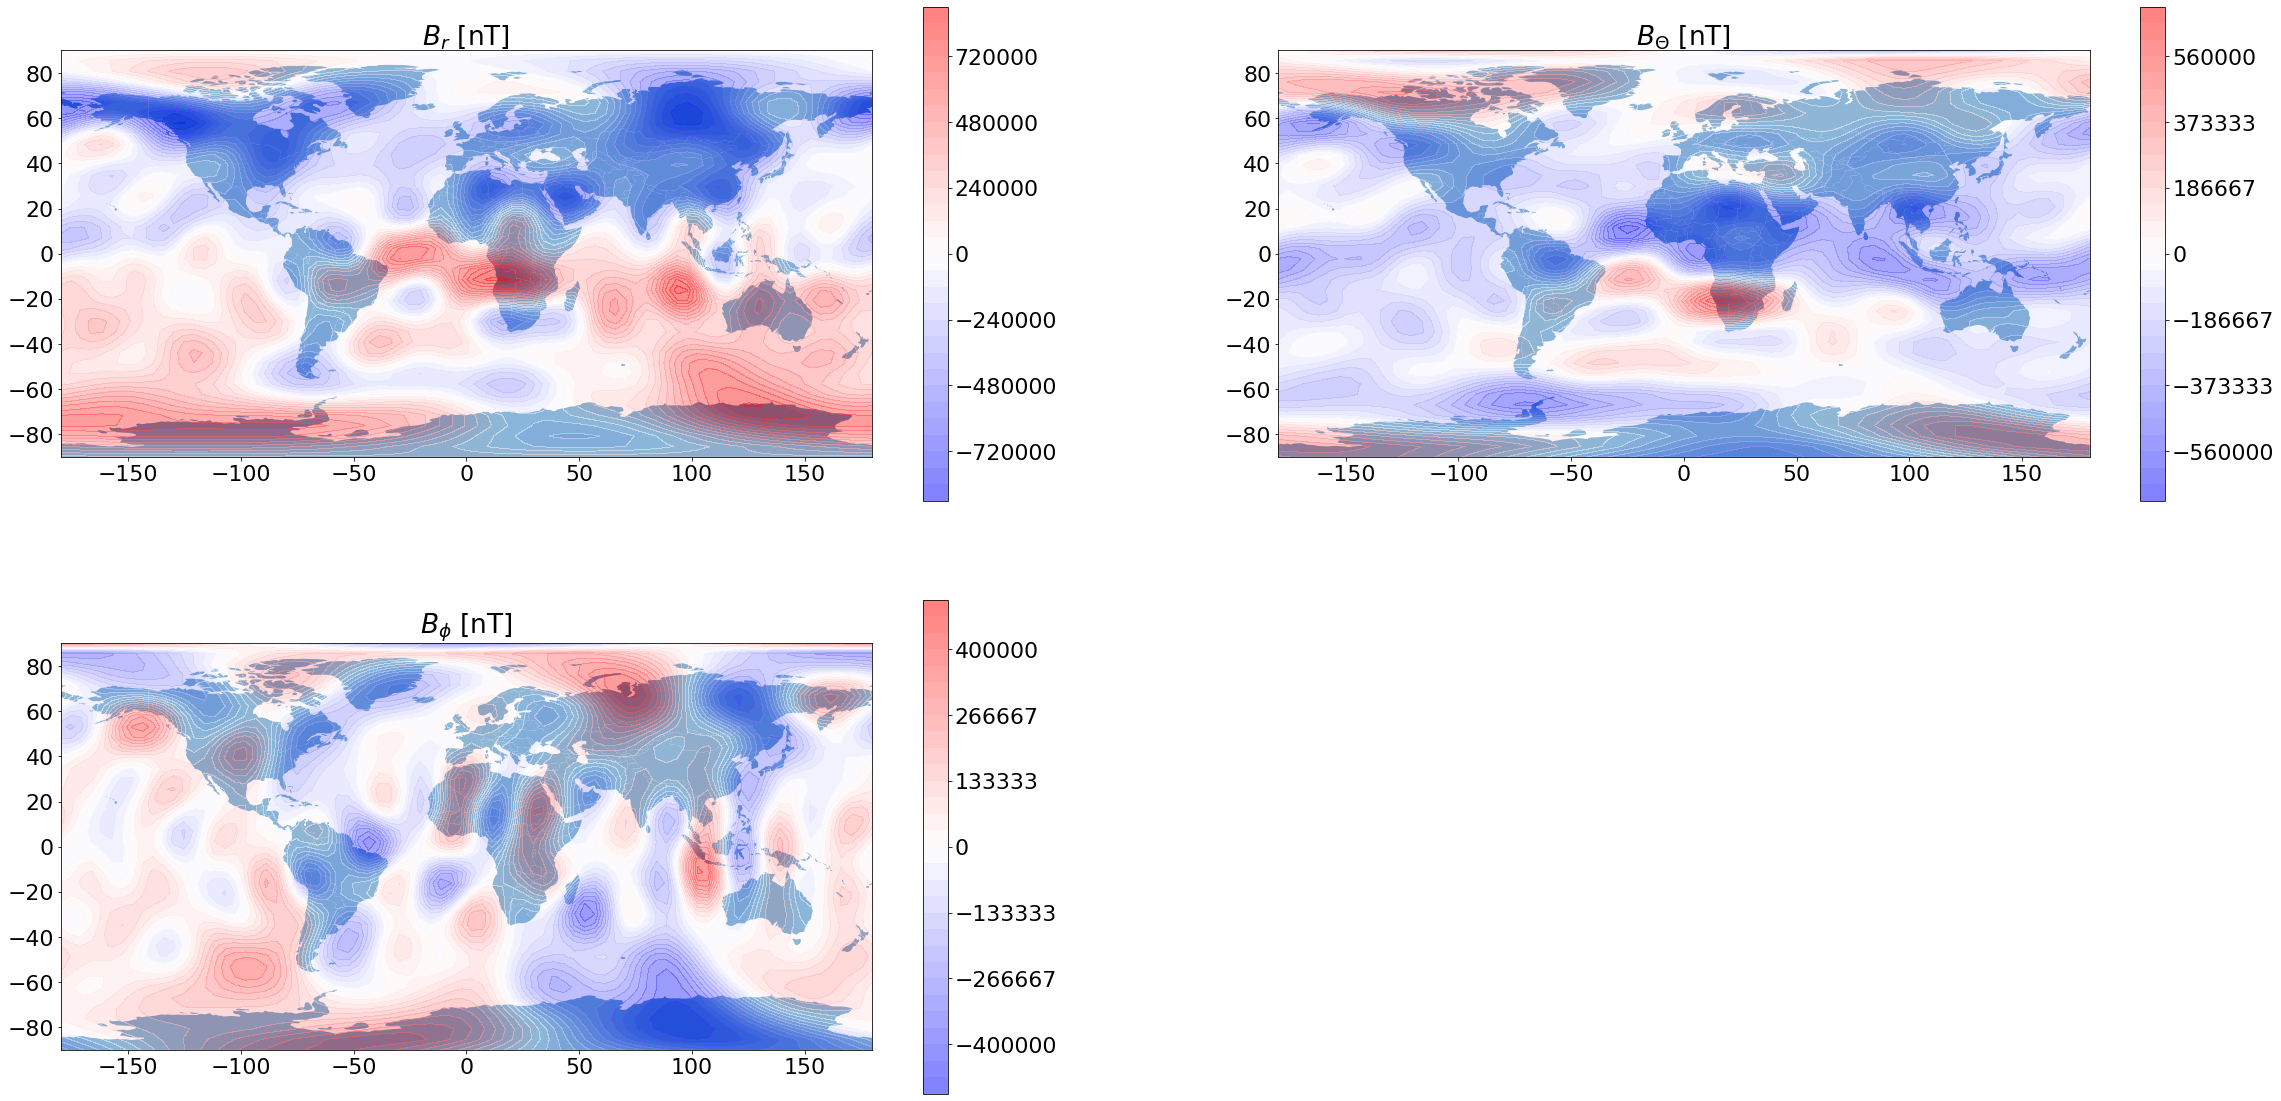

In [21]:
from functions import compute_gauss_coefs_vector, compute_grid_positions, compute_B_meshgrid, compute_B


#  possible dates ['2014-05', '2014-09', '2015-01', '2015-05', '2015-09, '2016-01', '2016-05', '2016-09', '2017-01', '2017-05' \\
#  '2017-09', 2018-01', '2018-05', '2018-09', '2019-01', '2019-05', '2019-09', '2020-01', '2020-05', '2020-09', '2021-01', '2021-05']
print('unique times list >', unique_times_list)

N_VO = 300
L_max = 13

#  Parameters 
date = '2017-09'

radius = 3485.0 # 6861
roundvalue = 10**5

#radius = 6861
#roundvalue = 10**3


# Extract the prior covariance matrix and creating the prior mean vector
cm_prior = np.loadtxt('./donnees/prior_cov_matrix.txt')
cdf_dir = './donnees/cdf_files_basic_sync_functions_201'

# Computing the our own gauss coefficient vector
X_CF = compute_gauss_coefs_vector(swarm_file, '2018-05', 13, 300, 'B_CF', 'sigma_CF', cm_prior)

## Plotting the geomagnetic field from our own model
# creating the different lists
eps = 10e-7
N = 40 # number of latitudes considered
th = np.linspace(-90+eps, 90+eps, N)
#ph = np.linspace(-180, 180, N)
ph = np.linspace(-180, 180, 2*N)
positions = compute_grid_positions(radius, th, ph, N)

# Compute B
B = compute_B(positions, N, L_max, X_CF)

#  plot field model inverted from Swarm data
fig = plt.figure(figsize=(40,20))
ph, th = np.meshgrid(ph, th)
#levels_B = lambda B: np.linspace(np.min(B), np.max(B), N)
BR_meshgrid = compute_B_meshgrid(B, 0, N)
Bth_meshgrid = compute_B_meshgrid(B, 1, N)
Bphi_meshgrid = compute_B_meshgrid(B, 2, N)

create_graph(fig, 221, world, th, ph, BR_meshgrid, "$B_r$ [nT]", Nlevels, roundvalue)
create_graph(fig, 222, world, th, ph, Bth_meshgrid, "$B_{\Theta}$ [nT]", Nlevels, roundvalue)
create_graph(fig, 223, world, th, ph, Bphi_meshgrid, "$B_{\phi}$ [nT]", Nlevels, roundvalue)
plt.show()


In [27]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from functions import compute_B, compute_grid_positions, compute_B_meshgrid, create_graph 

# choose date and radius for the CHAOS-7 field model
date = 2017.9 # see times_chaos values

#choose radius at which the field is represented (only valid above the core radius)
# core radius: 3485 km
# Swarm radius: 6861 km
# Earth's radius: 6381 km
radius = 6381 

# choose max spherical harmonic degree to be considered
L_max = 13 # max degree used in our gauss coefs vector 

N_max = L_max*(L_max+2) # number of spherical harmonic coef of degree n<=Lèmax

# Creation of the different lists (latitudes, longitudes...)
eps = 10e-7
N = 20 # number of different latitudes/longitudes for the grid
latitudes = np.linspace(0, 180, N)
#longitudes = np.linspace(-180, 180, N)
longitudes = np.linspace(-180, 180, 2*N)
th = 90 - latitudes + eps
ph = longitudes
positions = compute_grid_positions(radius, th, ph, N)
index_temps = np.argwhere(times_chaos == date)

my_X = gauss_coeffs[index_temps][0][0][:N_max]
# Creation of the MF list
B_chaos = compute_B(positions, N, L_max, my_X)


# Parameters for your model
your_date = '2017-09'
your_radius = 3485.0  # Update with the appropriate radius for your model
your_L_max = 13

# Extract your gauss coefficient vector
X_your = compute_gauss_coefs_vector(your_swarm_file, your_date, your_L_max, N_VO, 'B_CF', 'sigma_CF', cm_prior)

# Creating the grid for your model
your_positions = compute_grid_positions(your_radius, th, ph, N)

# Compute your model's magnetic field
B_your = compute_B(your_positions, N, your_L_max, X_your)

# Compute CHAOS-7 magnetic field
B_chaos = compute_B(chaos_positions, N, chaos_L_max, X_chaos)

# Plotting CHAOS-7 magnetic field
fig_chaos = plt.figure(figsize=(40, 20))
ph, th = np.meshgrid(ph, th)
BR_meshgrid_chaos = compute_B_meshgrid(B_chaos, 0, N)
Bth_meshgrid_chaos = compute_B_meshgrid(B_chaos, 1, N)
Bphi_meshgrid_chaos = compute_B_meshgrid(B_chaos, 2, N)

create_graph(fig_chaos, 221, world, th, ph, BR_meshgrid_chaos, "$B_r$ CHAOS-7 [nT]", Nlevels, roundvalue)
create_graph(fig_chaos, 222, world, th, ph, Bth_meshgrid_chaos, "$B_{\Theta}$ CHAOS-7 [nT]", Nlevels, roundvalue)
create_graph(fig_chaos, 223, world, th, ph, Bphi_meshgrid_chaos, "$B_{\phi}$ CHAOS-7 [nT]", Nlevels, roundvalue)

# Plotting your model's magnetic field
fig_your = plt.figure(figsize=(40, 20))
BR_meshgrid_your = compute_B_meshgrid(B_your, 0, N)
Bth_meshgrid_your = compute_B_meshgrid(B_your, 1, N)
Bphi_meshgrid_your = compute_B_meshgrid(B_your, 2, N)

create_graph(fig_your, 221, world, th, ph, BR_meshgrid_your, "$B_r$ Your Model [nT]", Nlevels, roundvalue)
create_graph(fig_your, 222, world, th, ph, Bth_meshgrid_your, "$B_{\Theta}$ Your Model [nT]", Nlevels, roundvalue)
create_graph(fig_your, 223, world, th, ph, Bphi_meshgrid_your, "$B_{\phi}$ Your Model [nT]", Nlevels, roundvalue)

plt.show()



IndexError: index 0 is out of bounds for axis 0 with size 0

unique times list > [numpy.datetime64('2014-05'), numpy.datetime64('2014-09'), numpy.datetime64('2015-01'), numpy.datetime64('2015-05'), numpy.datetime64('2015-09'), numpy.datetime64('2016-01'), numpy.datetime64('2016-05'), numpy.datetime64('2016-09'), numpy.datetime64('2017-01'), numpy.datetime64('2017-05'), numpy.datetime64('2017-09'), numpy.datetime64('2018-01'), numpy.datetime64('2018-05'), numpy.datetime64('2018-09'), numpy.datetime64('2019-01'), numpy.datetime64('2019-05'), numpy.datetime64('2019-09'), numpy.datetime64('2020-01'), numpy.datetime64('2020-05'), numpy.datetime64('2020-09'), numpy.datetime64('2021-01'), numpy.datetime64('2021-05')]
230000.0
150000.0
100000.0


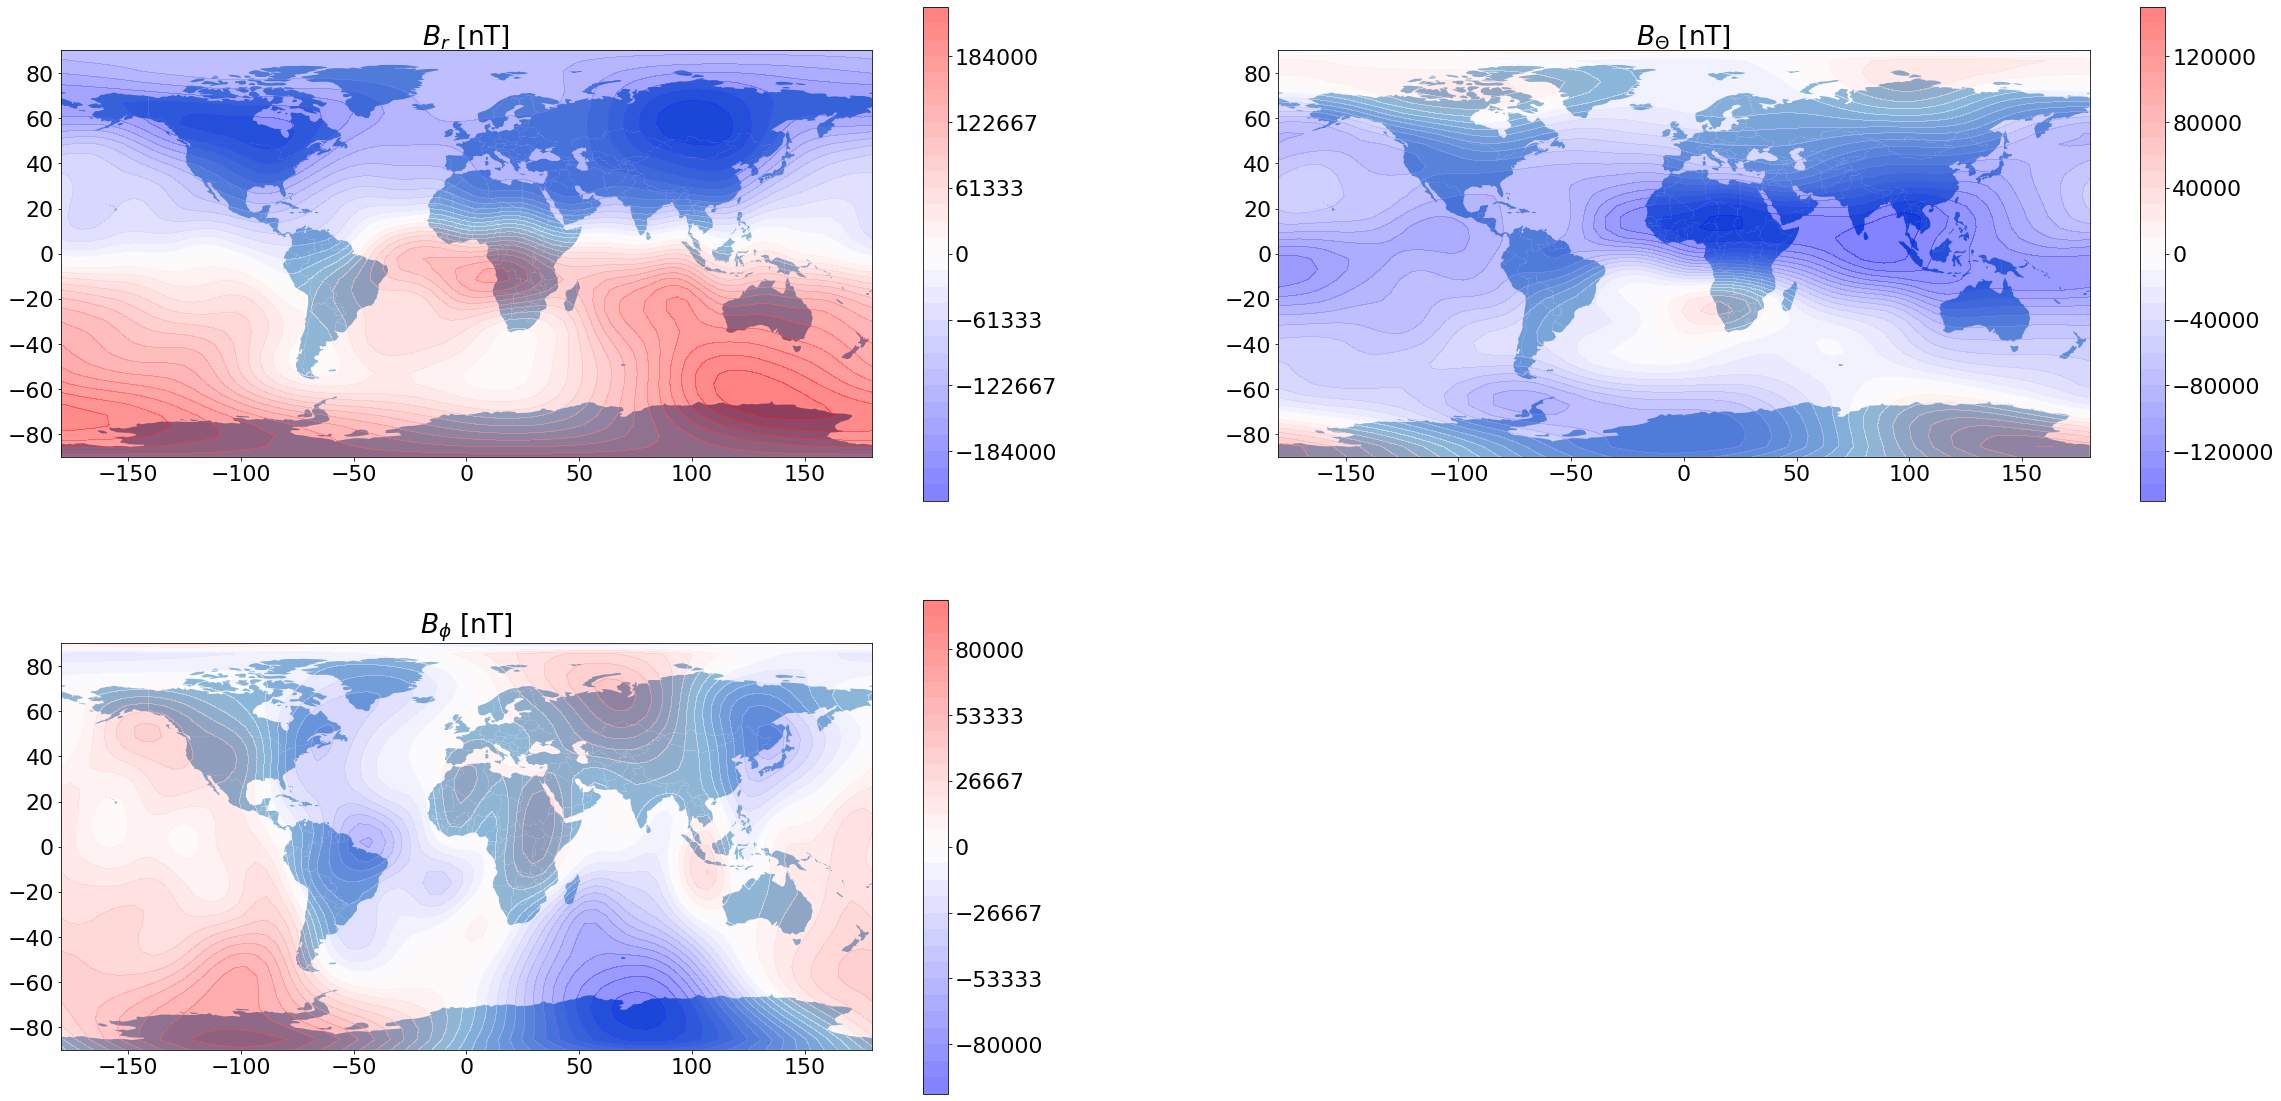

In [9]:
from functions import compute_gauss_coefs_vector, compute_grid_positions, compute_B_meshgrid, compute_B


#  possible dates ['2014-05', '2014-09', '2015-01', '2015-05', '2015-09, '2016-01', '2016-05', '2016-09', '2017-01', '2017-05' \\
#  '2017-09', 2018-01', '2018-05', '2018-09', '2019-01', '2019-05', '2019-09', '2020-01', '2020-05', '2020-09', '2021-01', '2021-05']
print('unique times list >', unique_times_list)

N_VO = 300
L_max = 13

#  Parameters 
date = '2017-09'

radius = 4500.0 # 6861
roundvalue = 10**4

#radius = 6861
#roundvalue = 10**3


# Extract the prior covariance matrix and creating the prior mean vector
cm_prior = np.loadtxt('./donnees/prior_cov_matrix.txt')
cdf_dir = './donnees/cdf_files_basic_sync_functions_201'

# Computing the our own gauss coefficient vector
X_CF = compute_gauss_coefs_vector(swarm_file, '2018-05', 13, 300, 'B_CF', 'sigma_CF', cm_prior)

## Plotting the geomagnetic field from our own model
# creating the different lists
eps = 10e-7
N = 40 # number of latitudes considered
th = np.linspace(-90+eps, 90+eps, N)
#ph = np.linspace(-180, 180, N)
ph = np.linspace(-180, 180, 2*N)
positions = compute_grid_positions(radius, th, ph, N)

# Compute B
B = compute_B(positions, N, L_max, X_CF)

#  plot field model inverted from Swarm data
fig = plt.figure(figsize=(40,20))
ph, th = np.meshgrid(ph, th)
#levels_B = lambda B: np.linspace(np.min(B), np.max(B), N)
BR_meshgrid = compute_B_meshgrid(B, 0, N)
Bth_meshgrid = compute_B_meshgrid(B, 1, N)
Bphi_meshgrid = compute_B_meshgrid(B, 2, N)

create_graph(fig, 221, world, th, ph, BR_meshgrid, "$B_r$ [nT]", Nlevels, roundvalue)
create_graph(fig, 222, world, th, ph, Bth_meshgrid, "$B_{\Theta}$ [nT]", Nlevels, roundvalue)
create_graph(fig, 223, world, th, ph, Bphi_meshgrid, "$B_{\phi}$ [nT]", Nlevels, roundvalue)
plt.show()


unique times list > [numpy.datetime64('2014-05'), numpy.datetime64('2014-09'), numpy.datetime64('2015-01'), numpy.datetime64('2015-05'), numpy.datetime64('2015-09'), numpy.datetime64('2016-01'), numpy.datetime64('2016-05'), numpy.datetime64('2016-09'), numpy.datetime64('2017-01'), numpy.datetime64('2017-05'), numpy.datetime64('2017-09'), numpy.datetime64('2018-01'), numpy.datetime64('2018-05'), numpy.datetime64('2018-09'), numpy.datetime64('2019-01'), numpy.datetime64('2019-05'), numpy.datetime64('2019-09'), numpy.datetime64('2020-01'), numpy.datetime64('2020-05'), numpy.datetime64('2020-09'), numpy.datetime64('2021-01'), numpy.datetime64('2021-05')]
153000.0
101000.0
54000.0


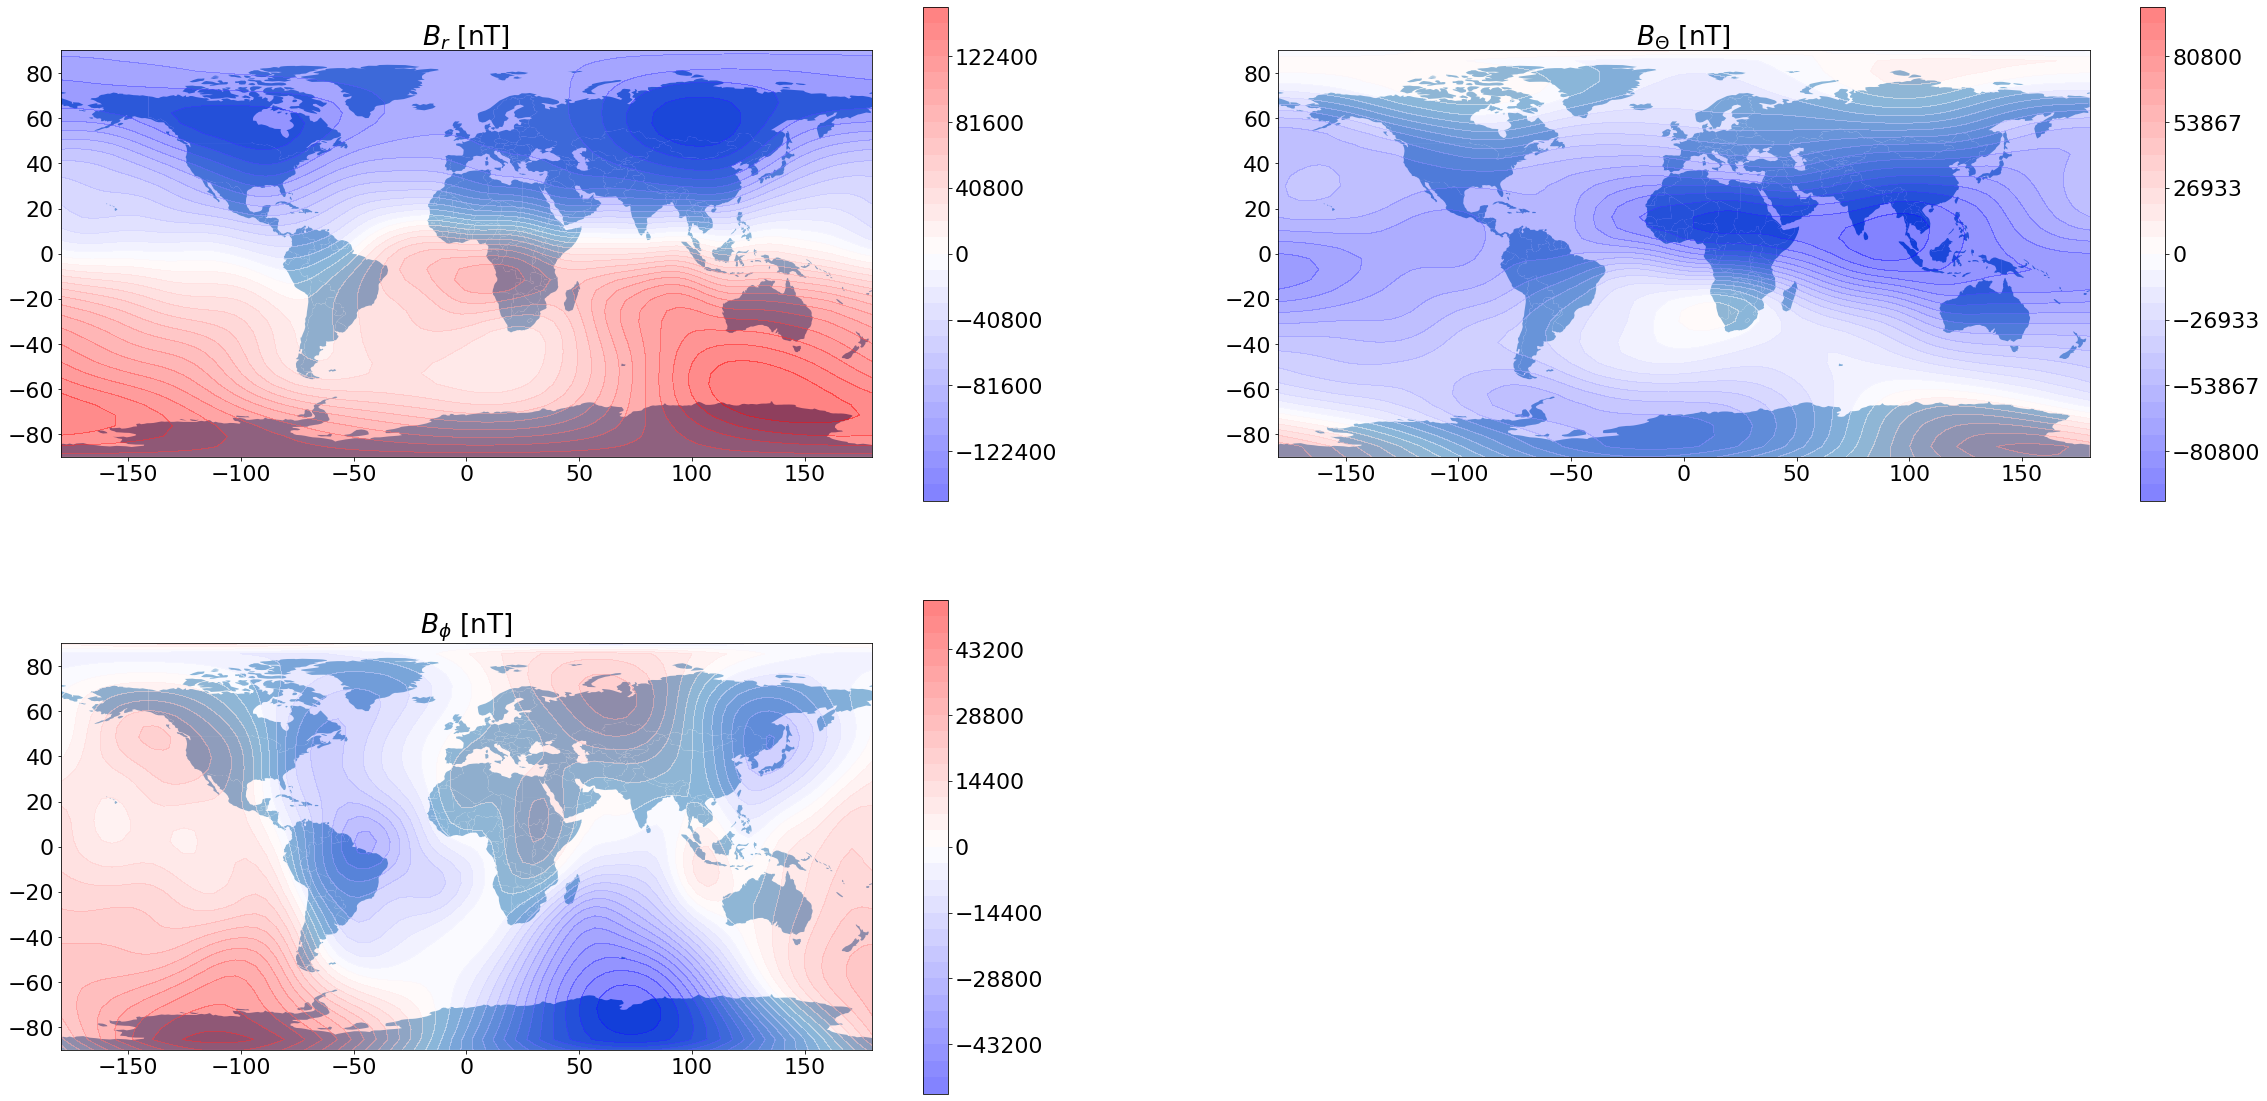

In [10]:
from functions import compute_gauss_coefs_vector, compute_grid_positions, compute_B_meshgrid, compute_B


#  possible dates ['2014-05', '2014-09', '2015-01', '2015-05', '2015-09, '2016-01', '2016-05', '2016-09', '2017-01', '2017-05' \\
#  '2017-09', 2018-01', '2018-05', '2018-09', '2019-01', '2019-05', '2019-09', '2020-01', '2020-05', '2020-09', '2021-01', '2021-05']
print('unique times list >', unique_times_list)

N_VO = 300
L_max = 13

#  Parameters 
date = '2017-09'

radius = 5000.0 # 6861
roundvalue = 10**3

#radius = 6861
#roundvalue = 10**3


# Extract the prior covariance matrix and creating the prior mean vector
cm_prior = np.loadtxt('./donnees/prior_cov_matrix.txt')
cdf_dir = './donnees/cdf_files_basic_sync_functions_201'

# Computing the our own gauss coefficient vector
X_CF = compute_gauss_coefs_vector(swarm_file, '2018-05', 13, 300, 'B_CF', 'sigma_CF', cm_prior)

## Plotting the geomagnetic field from our own model
# creating the different lists
eps = 10e-7
N = 40 # number of latitudes considered
th = np.linspace(-90+eps, 90+eps, N)
#ph = np.linspace(-180, 180, N)
ph = np.linspace(-180, 180, 2*N)
positions = compute_grid_positions(radius, th, ph, N)

# Compute B
B = compute_B(positions, N, L_max, X_CF)

#  plot field model inverted from Swarm data
fig = plt.figure(figsize=(40,20))
ph, th = np.meshgrid(ph, th)
#levels_B = lambda B: np.linspace(np.min(B), np.max(B), N)
BR_meshgrid = compute_B_meshgrid(B, 0, N)
Bth_meshgrid = compute_B_meshgrid(B, 1, N)
Bphi_meshgrid = compute_B_meshgrid(B, 2, N)

create_graph(fig, 221, world, th, ph, BR_meshgrid, "$B_r$ [nT]", Nlevels, roundvalue)
create_graph(fig, 222, world, th, ph, Bth_meshgrid, "$B_{\Theta}$ [nT]", Nlevels, roundvalue)
create_graph(fig, 223, world, th, ph, Bphi_meshgrid, "$B_{\phi}$ [nT]", Nlevels, roundvalue)
plt.show()


unique times list > [numpy.datetime64('2014-05'), numpy.datetime64('2014-09'), numpy.datetime64('2015-01'), numpy.datetime64('2015-05'), numpy.datetime64('2015-09'), numpy.datetime64('2016-01'), numpy.datetime64('2016-05'), numpy.datetime64('2016-09'), numpy.datetime64('2017-01'), numpy.datetime64('2017-05'), numpy.datetime64('2017-09'), numpy.datetime64('2018-01'), numpy.datetime64('2018-05'), numpy.datetime64('2018-09'), numpy.datetime64('2019-01'), numpy.datetime64('2019-05'), numpy.datetime64('2019-09'), numpy.datetime64('2020-01'), numpy.datetime64('2020-05'), numpy.datetime64('2020-09'), numpy.datetime64('2021-01'), numpy.datetime64('2021-05')]
53000.0
33000.0
13000.0


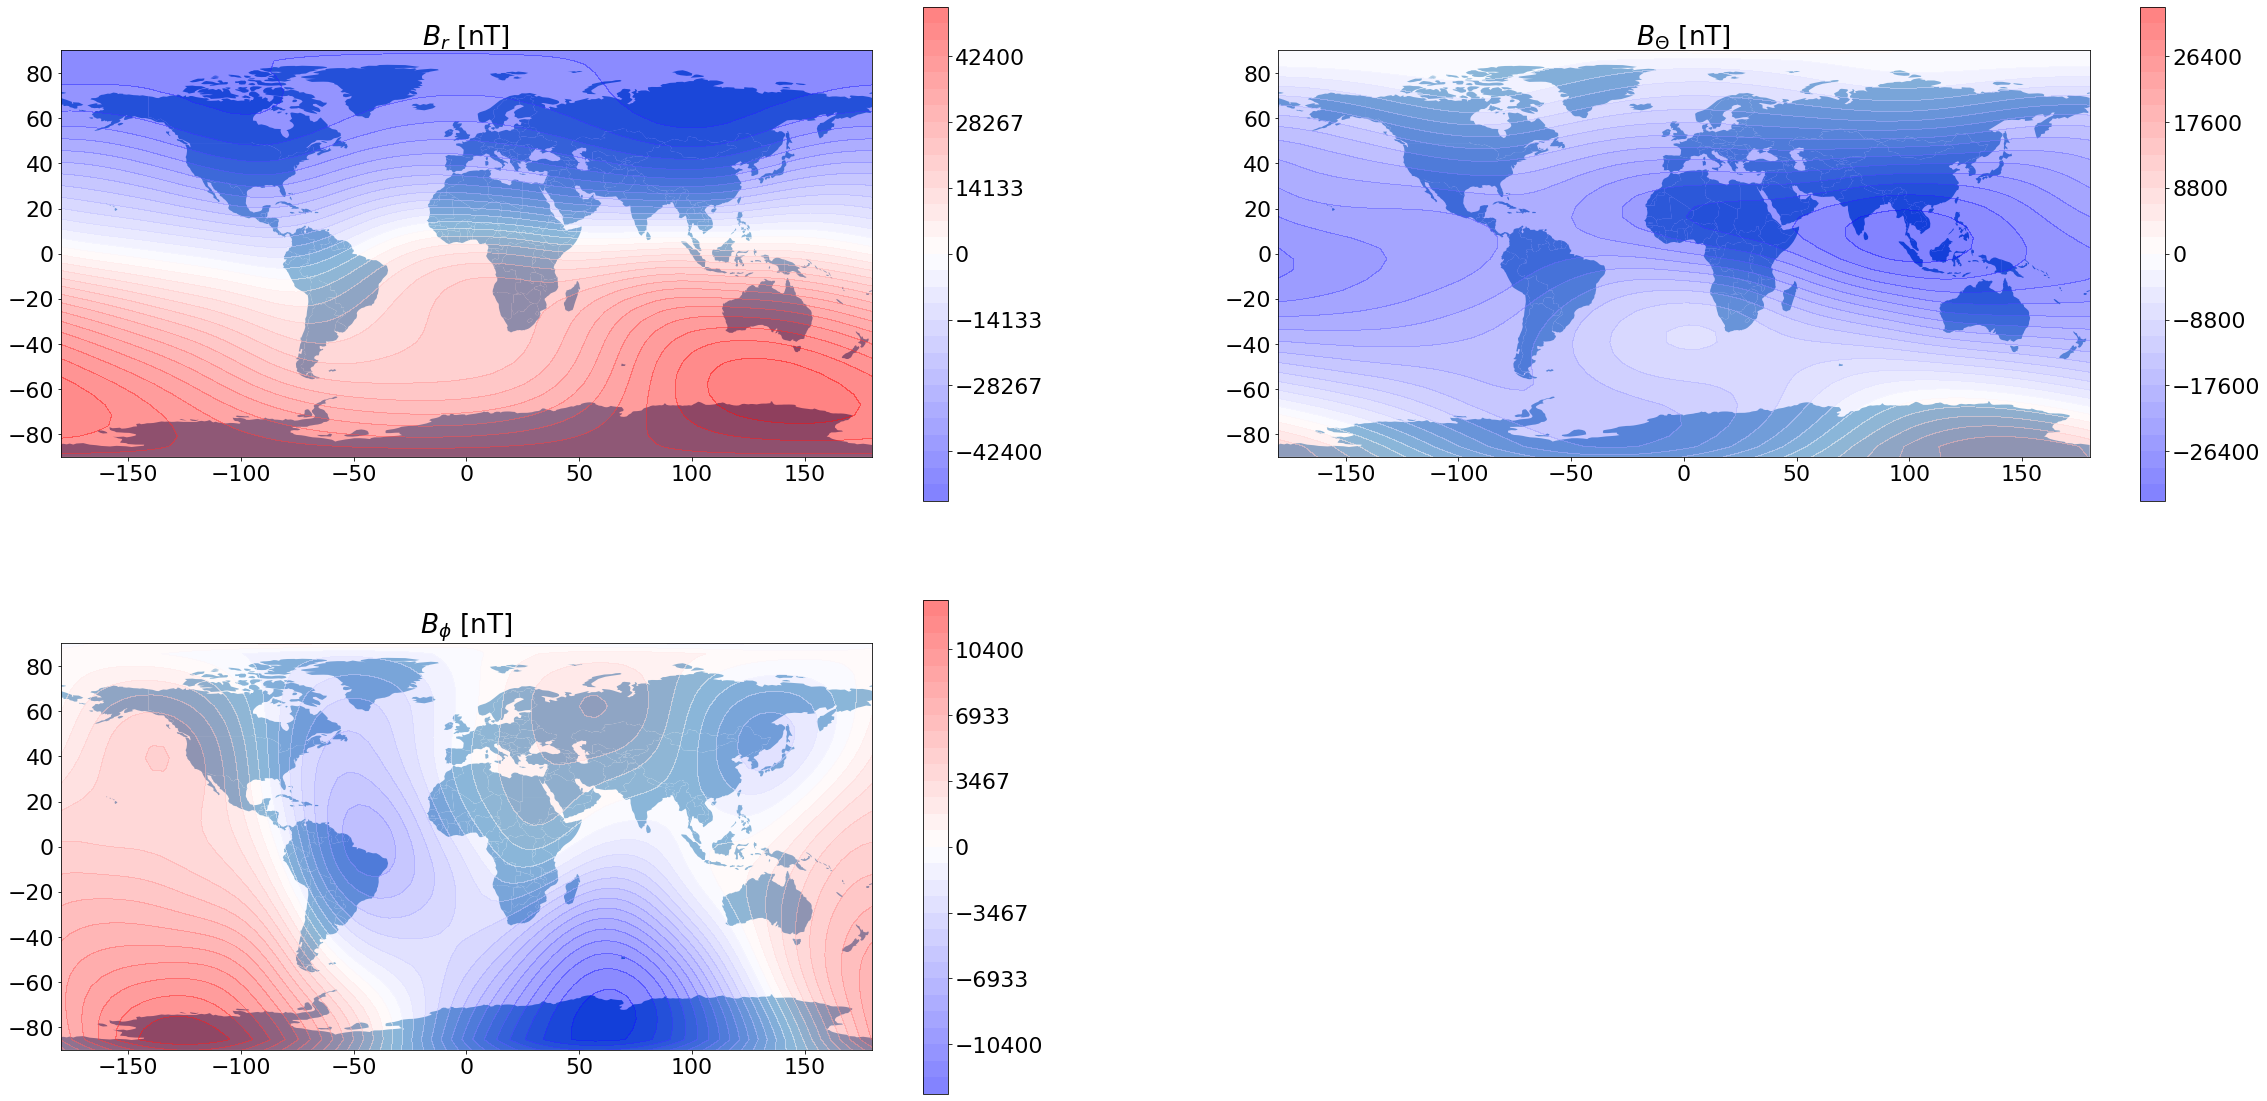

In [11]:
from functions import compute_gauss_coefs_vector, compute_grid_positions, compute_B_meshgrid, compute_B


#  possible dates ['2014-05', '2014-09', '2015-01', '2015-05', '2015-09, '2016-01', '2016-05', '2016-09', '2017-01', '2017-05' \\
#  '2017-09', 2018-01', '2018-05', '2018-09', '2019-01', '2019-05', '2019-09', '2020-01', '2020-05', '2020-09', '2021-01', '2021-05']
print('unique times list >', unique_times_list)

N_VO = 300
L_max = 13

#  Parameters 
date = '2017-09'

radius = 6861
roundvalue = 10**3


# Extract the prior covariance matrix and creating the prior mean vector
cm_prior = np.loadtxt('./donnees/prior_cov_matrix.txt')
cdf_dir = './donnees/cdf_files_basic_sync_functions_201'

# Computing the our own gauss coefficient vector
X_CF = compute_gauss_coefs_vector(swarm_file, '2018-05', 13, 300, 'B_CF', 'sigma_CF', cm_prior)

## Plotting the geomagnetic field from our own model
# creating the different lists
eps = 10e-7
N = 40 # number of latitudes considered
th = np.linspace(-90+eps, 90+eps, N)
#ph = np.linspace(-180, 180, N)
ph = np.linspace(-180, 180, 2*N)
positions = compute_grid_positions(radius, th, ph, N)

# Compute B
B = compute_B(positions, N, L_max, X_CF)

#  plot field model inverted from Swarm data
fig = plt.figure(figsize=(40,20))
ph, th = np.meshgrid(ph, th)
#levels_B = lambda B: np.linspace(np.min(B), np.max(B), N)
BR_meshgrid = compute_B_meshgrid(B, 0, N)
Bth_meshgrid = compute_B_meshgrid(B, 1, N)
Bphi_meshgrid = compute_B_meshgrid(B, 2, N)

create_graph(fig, 221, world, th, ph, BR_meshgrid, "$B_r$ [nT]", Nlevels, roundvalue)
create_graph(fig, 222, world, th, ph, Bth_meshgrid, "$B_{\Theta}$ [nT]", Nlevels, roundvalue)
create_graph(fig, 223, world, th, ph, Bphi_meshgrid, "$B_{\phi}$ [nT]", Nlevels, roundvalue)
plt.show()


In [12]:
from functions import compute_gauss_coefs_vector, compute_grid_positions, compute_B_meshgrid, compute_B


#  possible dates ['2014-05', '2014-09', '2015-01', '2015-05', '2015-09, '2016-01', '2016-05', '2016-09', '2017-01', '2017-05' \\
#  '2017-09', 2018-01', '2018-05', '2018-09', '2019-01', '2019-05', '2019-09', '2020-01', '2020-05', '2020-09', '2021-01', '2021-05']
print('unique times list >', unique_times_list)

N_VO = 300
L_max = 5

#  Parameters 
date = '2017-09'

radius = 3485.0 # 6861
roundvalue = 10**5

#radius = 6861
#roundvalue = 10**3


# Extract the prior covariance matrix and creating the prior mean vector
cm_prior = np.loadtxt('./donnees/prior_cov_matrix.txt')
cdf_dir = './donnees/cdf_files_basic_sync_functions_201'

# Computing the our own gauss coefficient vector
X_CF = compute_gauss_coefs_vector(swarm_file, '2018-05', 13, 300, 'B_CF', 'sigma_CF', cm_prior)

## Plotting the geomagnetic field from our own model
# creating the different lists
eps = 10e-7
N = 40 # number of latitudes considered
th = np.linspace(-90+eps, 90+eps, N)
#ph = np.linspace(-180, 180, N)
ph = np.linspace(-180, 180, 2*N)
positions = compute_grid_positions(radius, th, ph, N)

# Compute B
B = compute_B(positions, N, L_max, X_CF)

#  plot field model inverted from Swarm data
fig = plt.figure(figsize=(40,20))
ph, th = np.meshgrid(ph, th)
#levels_B = lambda B: np.linspace(np.min(B), np.max(B), N)
BR_meshgrid = compute_B_meshgrid(B, 0, N)
Bth_meshgrid = compute_B_meshgrid(B, 1, N)
Bphi_meshgrid = compute_B_meshgrid(B, 2, N)

create_graph(fig, 221, world, th, ph, BR_meshgrid, "$B_r$ [nT]", Nlevels, roundvalue)
create_graph(fig, 222, world, th, ph, Bth_meshgrid, "$B_{\Theta}$ [nT]", Nlevels, roundvalue)
create_graph(fig, 223, world, th, ph, Bphi_meshgrid, "$B_{\phi}$ [nT]", Nlevels, roundvalue)
plt.show()


unique times list > [numpy.datetime64('2014-05'), numpy.datetime64('2014-09'), numpy.datetime64('2015-01'), numpy.datetime64('2015-05'), numpy.datetime64('2015-09'), numpy.datetime64('2016-01'), numpy.datetime64('2016-05'), numpy.datetime64('2016-09'), numpy.datetime64('2017-01'), numpy.datetime64('2017-05'), numpy.datetime64('2017-09'), numpy.datetime64('2018-01'), numpy.datetime64('2018-05'), numpy.datetime64('2018-09'), numpy.datetime64('2019-01'), numpy.datetime64('2019-05'), numpy.datetime64('2019-09'), numpy.datetime64('2020-01'), numpy.datetime64('2020-05'), numpy.datetime64('2020-09'), numpy.datetime64('2021-01'), numpy.datetime64('2021-05')]


ValueError: shapes (3,35) and (195,) not aligned: 35 (dim 1) != 195 (dim 0)

**now some extra...**

1) Under the Gaussian assumptions made so far, a posteriori uncertainties can be estimated from the posterior covariance matrix. It is given by 
\begin{equation}
\hat{\sf P} =\left({\sf H}^T {\sf R}^{-1} {\sf H} +  
{\sf P}^{-1}\right)^{-1}\,.
\end{equation}
The diagonal elements of $\hat{\sf P}$ give a hint of the uncertainties on the model coefficients. One can see that if the data errors (stored in ${\sf R}$) are infinitely large, then the "weight" of the data is negligeable, and then $\hat{\sf P}$ will be close to ${\sf P}$, meaning that we have not learnt much on the model, and $\hat{\bf x}$ will be close to the background.
In the opposite case, observation will reduce the spread of the possible models (recall the product of two Gaussians in TP no.1). 

- **now calculate the matrix $\hat{\sf P}$, and estimate posterior uncertainties on the Gauss coefficients in various cases (obs or core virtual observatory data)... (the requested operators that can be extracted from the function compute_gauss_coefs_vector...)**

2) build a field model only from data at latitudes less than 60 degrees... which differences with a field model built from alla available observations?


## references

Aubert, J., & Gillet, N. (2021). The interplay of fast waves and slow convection in geodynamo simulations nearing Earth’s core conditions. Geophys. J. Int., 225(3), 1854-1873.

Finlay, C. C., Kloss, C., Olsen, N., Hammer, M. D., Tøffner-Clausen, L., Grayver, A., & Kuvshinov, A. (2020). The CHAOS-7 geomagnetic field model and observed changes in the South Atlantic Anomaly. Earth, Planets and Space, 72(1), 1-31

Hammer, M. D., Finlay, C. C., & Olsen, N. (2021). Applications for CryoSat-2 satellite magnetic data in studies of Earth’s core field variations. Earth, Planets and Space, 73(1), 1-22.


In [65]:
def compute_gauss_coefs_vector_and_cov_matrix(file, date_chosen, max_degree, N_VO, measure_MF, measure_sigma, cm_prior):
    cdf_read = cdflib.CDF(file)
    info = cdf_read.cdf_info()
    zvars = info.zVariables
    alldata = {name: cdf_read.varget(name) for name in zvars}
    times = cdf_times_to_np_date(alldata['Timestamp'])
    unique_times = compute_unique_times_list(times)
    list_sigma_obs = compute_obs_vector_at_t(alldata, date_chosen, N_VO, measure_sigma, unique_times)
    obs_vec_at_t = compute_obs_vector_at_t(alldata, date_chosen, N_VO, measure_MF, unique_times)
    r, th, ph, list_coords_obs = compute_list_coords_obs_at_t(date_chosen, alldata, unique_times, N_VO)
    obs_vec_at_t, list_coords_obs, list_sigma_obs = delete_nan_values(obs_vec_at_t, list_coords_obs,
                                                                            list_sigma_obs)
    cm_obs = compute_cov_matrix_obs_at_t(list_sigma_obs)
    H = compute_direct_obs_operator(list_coords_obs, max_degree)
    mean_prior = np.zeros(max_degree * (max_degree + 2))
    sigma_obs_inv = np.linalg.inv(cm_obs)
    sigma_prior_inv = np.linalg.inv(cm_prior)
    n_max = max_degree*(max_degree+2)
    # Kalman gain
    Kalman_gain = np.linalg.inv(H.T @ sigma_obs_inv @ H + sigma_prior_inv[:n_max, :n_max])
    cov_matrix_inv = sigma_prior_inv[:n_max, :n_max] - Kalman_gain @ H.T @ sigma_obs_inv @ H @ Kalman_gain.T
    # Calculate the posterior covariance matrix
    posterior_cov_matrix_inv = np.linalg.inv(cov_matrix_inv)
    return posterior_cov_matrix_inv

cm_prior = np.loadtxt('./donnees/prior_cov_matrix.txt')
cdf_dir = './donnees/cdf_files_basic_sync_functions_201'



In [66]:
post_cov_matrix = compute_gauss_coefs_vector_and_cov_matrix(swarm_file, '2018-05', 13, 300, 'B_CF', 'sigma_CF', cm_prior)
print(post_cov_matrix)
print(len(post_cov_matrix))

[[-3.43151657e+02  5.37656263e+01  1.75696752e+01 ... -2.61848080e+00
   2.55350588e+00  7.89224887e-01]
 [ 5.37656263e+01 -3.37316523e+02  9.94281552e+00 ...  1.01383239e+00
  -9.16729203e-01  1.58267469e-01]
 [ 1.75696752e+01  9.94281552e+00 -3.17182707e+02 ...  3.84105365e-01
  -9.83697685e-02 -1.19544811e-01]
 ...
 [-2.61848080e+00  1.01383239e+00  3.84105365e-01 ...  3.06918222e-01
   5.00439835e-02  4.09282165e-02]
 [ 2.55350588e+00 -9.16729203e-01 -9.83697685e-02 ...  5.00439835e-02
   4.17958316e-01 -2.99880770e-04]
 [ 7.89224887e-01  1.58267469e-01 -1.19544811e-01 ...  4.09282165e-02
  -2.99880770e-04  6.21050785e-01]]
195


In [59]:
# Extract diagonal elements for uncertainties
coeff_uncertainties = np.diag(post_cov_matrix)
print("Posterior uncertainties on Gauss coefficients:", coeff_uncertainties)
print(len(coeff_uncertainties))

Posterior uncertainties on Gauss coefficients: [-3.43151657e+02 -3.37316523e+02 -3.17182707e+02 -3.07394739e+02
 -4.11877098e+02 -3.64164367e+02 -5.06313722e+02 -4.78983236e+02
 -3.02422229e+02 -4.49802714e+02 -4.80812544e+02 -4.88703476e+02
 -5.33982071e+02 -6.28064606e+02 -5.69026453e+02 -3.78939031e+02
 -4.16284200e+02 -4.65258024e+02 -5.80186781e+02 -5.88788555e+02
 -6.31742512e+02 -5.53913061e+02 -6.50594770e+02 -7.13173912e+02
 -6.43210952e+02 -4.39323163e+02 -8.12950842e+02 -4.79383913e+02
 -4.63781690e+02 -5.94675355e+02 -6.08794883e+02 -6.30633473e+02
 -6.62938910e+02 -6.48577819e+02 -7.80123116e+02 -4.07633728e+02
 -2.23762385e+02 -2.38357611e+02 -4.58648255e+02 -3.87942895e+02
 -6.00007470e+02 -6.54111275e+02 -6.90556884e+02 -9.37906502e+02
 -6.17629457e+02 -7.91957719e+02 -9.05627148e+02 -8.67188671e+02
 -4.31431308e+02 -3.26790860e+02 -7.08693925e+02 -1.76842207e+02
 -4.14980106e+02 -1.40878805e+02 -9.33841739e+02 -1.28181148e+03
 -8.48519515e+02 -1.31860390e+03 -2.2199517

1440000.0
1070000.0
760000.0


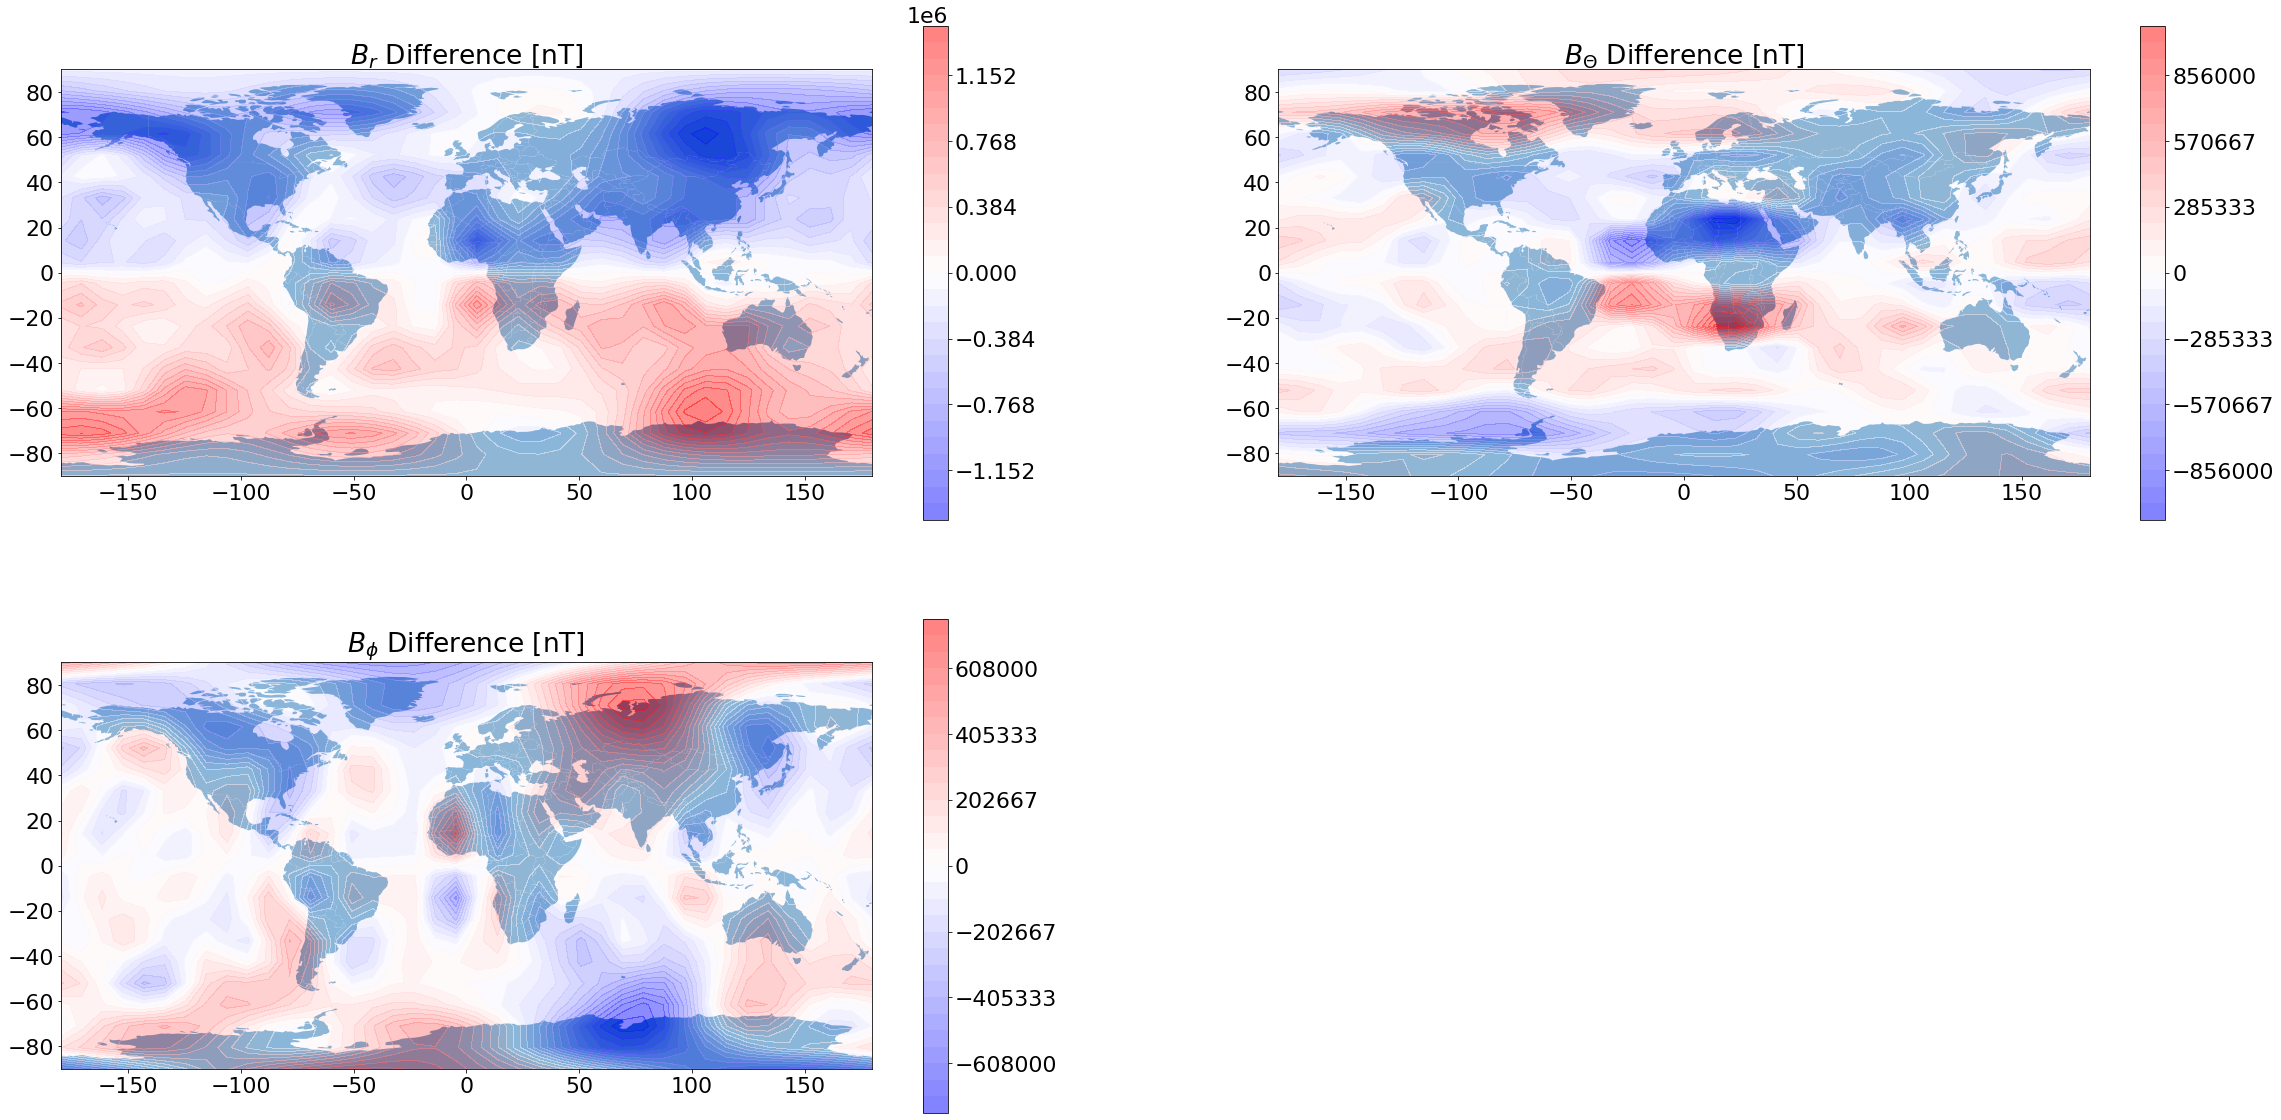

In [29]:
# Plotting the differences
fig_diff = plt.figure(figsize=(40,20))
BR_diff_meshgrid = compute_B_meshgrid(B_diff, 0, N)
Bth_diff_meshgrid = compute_B_meshgrid(B_diff, 1, N)
Bphi_diff_meshgrid = compute_B_meshgrid(B_diff, 2, N)

create_graph(fig_diff, 221, world, th, ph, BR_diff_meshgrid, "$B_r$ Difference [nT]", Nlevels, roundvalue)
create_graph(fig_diff, 222, world, th, ph, Bth_diff_meshgrid, "$B_{\Theta}$ Difference [nT]", Nlevels, roundvalue)
create_graph(fig_diff, 223, world, th, ph, Bphi_diff_meshgrid, "$B_{\phi}$ Difference [nT]", Nlevels, roundvalue)

plt.show()

In [30]:
mae = np.mean(np.abs(B_diff))
rmse = np.sqrt(np.mean(B_diff**2))

In [31]:
print("mae:", mae)
print("rmse:", rmse)

mae: 259462.87538358071
rmse: 365755.5088081315


In [ ]:
#build a field model only from data at latitudes less than 60 degrees... which differences with a field model built from alla available observations


from functions import compute_gauss_coefs_vector, compute_grid_positions, compute_B_meshgrid, compute_B


#  possible dates ['2014-05', '2014-09', '2015-01', '2015-05', '2015-09, '2016-01', '2016-05', '2016-09', '2017-01', '2017-05' \\
#  '2017-09', 2018-01', '2018-05', '2018-09', '2019-01', '2019-05', '2019-09', '2020-01', '2020-05', '2020-09', '2021-01', '2021-05']
print('unique times list >', unique_times_list)

N_VO = 300
L_max = 13

#  Parameters 
date = '2017-09'

radius = 4500.0 # 6861
roundvalue = 10**4

#radius = 6861
#roundvalue = 10**3


# Extract the prior covariance matrix and creating the prior mean vector
cm_prior = np.loadtxt('./donnees/prior_cov_matrix.txt')
cdf_dir = './donnees/cdf_files_basic_sync_functions_201'

# Computing the our own gauss coefficient vector
X_CF = compute_gauss_coefs_vector(swarm_file, '2018-05', 13, 300, 'B_CF', 'sigma_CF', cm_prior)

## Plotting the geomagnetic field from our own model
# creating the different lists
eps = 10e-7
N = 40 # number of latitudes considered
th = np.linspace(-90+eps, 90+eps, N)
#ph = np.linspace(-180, 180, N)
ph = np.linspace(-180, 180, 2*N)
positions = compute_grid_positions(radius, th, ph, N)

# Compute B
B = compute_B(positions, N, L_max, X_CF)

#  plot field model inverted from Swarm data
fig = plt.figure(figsize=(40,20))
ph, th = np.meshgrid(ph, th)
#levels_B = lambda B: np.linspace(np.min(B), np.max(B), N)
BR_meshgrid = compute_B_meshgrid(B, 0, N)
Bth_meshgrid = compute_B_meshgrid(B, 1, N)
Bphi_meshgrid = compute_B_meshgrid(B, 2, N)

create_graph(fig, 221, world, th, ph, BR_meshgrid, "$B_r$ [nT]", Nlevels, roundvalue)
create_graph(fig, 222, world, th, ph, Bth_meshgrid, "$B_{\Theta}$ [nT]", Nlevels, roundvalue)
create_graph(fig, 223, world, th, ph, Bphi_meshgrid, "$B_{\phi}$ [nT]", Nlevels, roundvalue)
plt.show()




# Assuming you have the necessary parameters
obs_lat_threshold = 60.0

# Filter observations based on latitude
obs_indices = np.where(np.abs(list_coords_obs[:, 1]) < obs_lat_threshold)[0]
obs_vec = obs_vec_at_t[filtered_obs_indices]
coords_obs = list_coords_obs[filtered_obs_indices]










